In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import sys

In [2]:
os.chdir("../../")
training_dir = "training"
checkpoint_dir = f"{training_dir}/checkpoints"
model_dir = f"{training_dir}/models"
evaluator_dir = "analysis/src/evaluation/model"
analysis_dir = "data/analysis"

In [3]:
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f != "latest.json"])
checkpoints = [json.loads(json.load(open(f"{checkpoint_dir}/{file}"))[1]) for file in checkpoint_files]

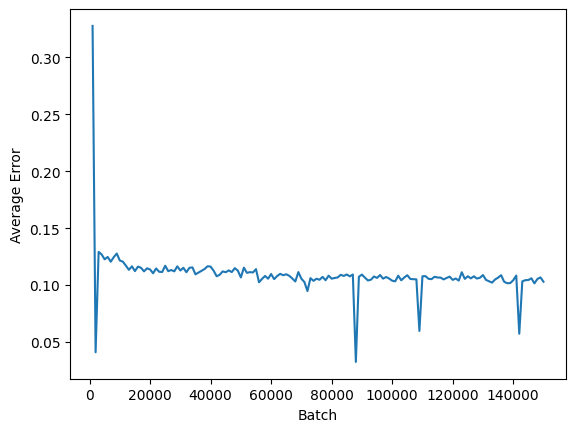

In [4]:
batch = [c["batch"] for c in checkpoints]
error = [c["error"] for c in checkpoints]

plt.plot(batch, error)
plt.xlabel("Batch")
plt.ylabel("Average Error")
plt.show()

In [5]:
def normalized(x):
    return x / max(abs(x))

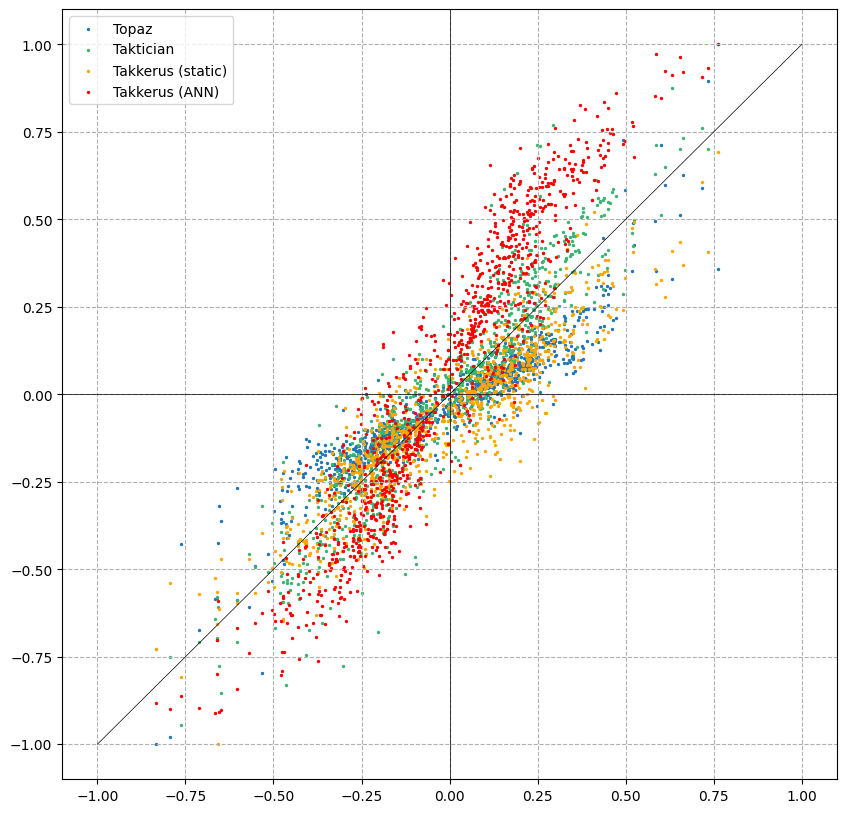

In [6]:
matplotlib.rc('figure', figsize=(10, 10))

subprocess.run(["cp", f"{model_dir}/latest.json", f"{evaluator_dir}/model_6s.json"])

takkerus_ann = normalized(np.array(json.loads(subprocess.run(
    ["cargo", "run", "--bin", "evaluate_positions", "--features", "tools", "--", "data/comparison_set.json"],
    capture_output=True,
    text=True,
).stdout)))

takkerus_static = normalized(np.array(json.load(open("data/takkerus_static_evaluations.json"))))
topaz = normalized(np.array(json.load(open("data/topaz_evaluations.json"))))
taktician = normalized(np.array(json.load(open("data/taktician_evaluations.json"))))

baseline = (takkerus_ann + takkerus_static + topaz + taktician) / 4.0

ax = plt.gca()
ax.grid(True, which="both", linestyle="--")
ax.axhline(color="black", linewidth=0.5)
ax.axvline(color="black", linewidth=0.5)

plt.plot([-1.0, 1.0], [-1.0, 1.0], linestyle="-", linewidth=0.5, color="black")
plt.scatter(baseline, topaz, s=2, label="Topaz")
plt.scatter(baseline, taktician, s=2, label="Taktician", color="mediumseagreen")
plt.scatter(baseline, takkerus_static, s=2, label="Takkerus (static)", color="orange")
plt.scatter(baseline, takkerus_ann, s=2, label="Takkerus (ANN)", color="red")
plt.scatter
plt.legend(loc="upper left")
plt.show()

In [ ]:
positions = json.load(open("data/comparison_set.json"))

p = subprocess.Popen(["../taktician/taktician", "tei"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)
#p = subprocess.Popen(["../topaz-tak/target/debug/topaz"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)

p.stdin.write("tei\n")
p.stdin.flush()
for _ in range(0, 3):
    p.stdout.readline()
    
evaluations = []
for position in positions:
    p.stdin.write(f"teinewgame 6\nposition tps {position}\ngo\n")
    p.stdin.flush()
    evaluation = int(p.stdout.readline().strip())
    evaluations.append(evaluation)
    
p.terminate()

In [ ]:
with open("data/taktician_evaluations.json", "w") as f:
    f.write(f"{json.dumps(evaluations, indent=2)}\n")